# Laboratorium 3 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab3`
 * zainstaluj potrzebne biblioteki:
 `pip install matplotlib`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [1]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from math import log, sqrt
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # w tym pakiet ze srodowiskiem testowym

In [2]:
# inicjalizujemy parametry testu

arms_number = 50
runs = 50
epochs = 1440
recommendation_size = 10

In [4]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny

arms = {}
for i in range(50):
    activation_probability = uniform(0.01, 0.7)
    mu = uniform(0.1, 2.5)
    sigma = min(uniform(0.1, 1), mu)
    arms['%s' % i] = Arm('%s' % i, activation_probability, lambda: normalvariate(mu, sigma))

arm_ids = list(arms.keys())
print(arm_ids)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']


In [5]:
# pierwszy bandyta - wybiera losowe ramiona
from random import choice

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        tmp_ids = self.arm_ids.copy()
        to_ret = []
        for _ in range(size):
            tmp = choice(tmp_ids)
            to_ret.append(tmp)
            tmp_ids.remove(tmp)
        return to_ret#...
    
    def feedback(self, arm_id, payout):
        pass

In [6]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [7]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [8]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 5059.9097124856735
random: 3189.2718571993523


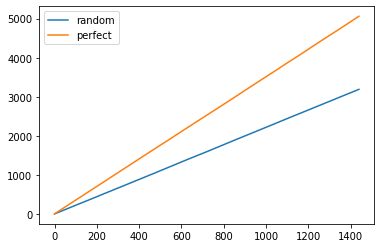

In [9]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 3.5274887068398657
random: 2.3085103526655657


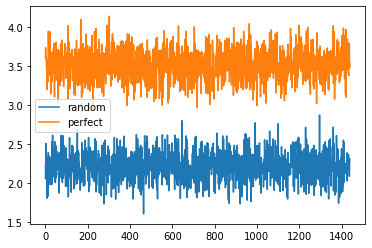

In [10]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [39]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        top_n = [x[0] for x in sorted(self.payouts_per_recommendation.items(), key=lambda x: x[1], reverse=True)]
        randomized = copy(self.arm_ids)
        shuffle(randomized)
        
        recommendation = []
        
        i = 0
        
        for _ in range(size):
            
            random_number = random()

            if random_number > self.epsilon:
                while top_n[i] in recommendation: i += 1
                recommendation.append(top_n[i])
            elif random_number <= self.epsilon:
                while randomized[i] in recommendation: i += 1
                recommendation.append(randomized[i])
            
            i+=1
                
            # ...

        return recommendation
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        div = self.recommended_rates[arm_id]
        if div == 0: div = 1
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / div

In [43]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        N = sum(self.recommended_rates.values())
        if N == 0: N = 1
        
        optimism_for_all = {}
        for arm_id in self.arm_ids:
            optimism_for_all[arm_id] = self.payouts_per_recommendation[arm_id] + self.optimism_weight * self._optimism(arm_id, N)
            
        
        # ...
        top_n_plus_optimism = [x[0] for x in sorted(optimism_for_all.items(), key=lambda x: x[1], reverse=True)][:size]
#         recommendation = []
        return top_n_plus_optimism
    
    def feedback(self, arm_id, payout):
        if payout > 0:
            self.activation_rates[arm_id] += 1
        self.payouts[arm_id] += payout
        div = self.recommended_rates[arm_id]
        if div == 0: div = 1
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / div

    def _optimism(self, arm, N):
        Ni = self.recommended_rates[arm]
        if Ni == 0: Ni = 1
        return sqrt((2*log(Ni))/(N))# ...
    
# optimism_weight = 0.1
# b = UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight)
# b.recommend(5)

In [36]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        beta_value = {}
        for arm_id in self.arm_ids:
            beta_value[arm_id] = betavariate(self.a[arm_id], self.b[arm_id])
            
        recommendation = [x[0] for x in sorted(beta_value.items(), key=lambda x: x[1], reverse=True)][:size]
        # ...
        
        return recommendation
    
    def feedback(self, arm_id, payout):
        reward = payout * self.reward_multiplier
        regret = max(1 - payout, 0) * self.regret_multiplier
        self.a[arm_id] += reward
        self.b[arm_id] += regret

## Część 3. - porównanie bandytów

In [40]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in [(1, 1), (10, 1), (1, 10), (10, 10)]])


In [41]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_10_1
Simulating: ts_1_10
Simulating: ts_10_10



Aggregated results:

perfect: 5079.929084114623
ts_1_10: 5049.515451076019
ts_1_1: 5032.078675097105
ts_10_1: 5025.858145901902
ts_10_10: 5004.8184263185285
egreedy_0.1: 3988.6905130023865
egreedy_0.01: 3889.1165340319976
egreedy_0.25: 3883.6665801817294
egreedy_0.05: 3878.2616377005315
ucb_10: 3493.786298010078
ucb_0.1: 3490.3816287516597
ucb_1: 3489.584987737054
ucb_0.01: 3487.9908352290863
random: 3187.6183521567673


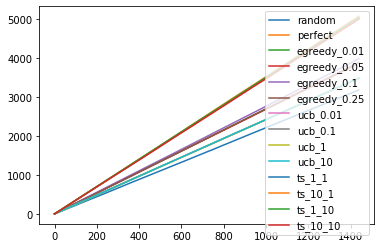

In [42]:
runner.plot_results(results, runs, epochs, mode='cumulative')